# Set Up
## Import

In [2]:
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time

## Settings

In [37]:
#CAUTION: if R is chosen too small and N too high, then when the program will try to calculate the inverse of dGr
# in the calculation of the saturated density profile, the following error will show: 'Matrix singular to numerical precision.'
# for example, for R=0.75, N=1000 is too high.  
R=0.75#cm
H=0.2 #cm
N=500
M=200
position_of_electrons=100

hr=R/N
hz=H/M

e=4.80324e-10

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

eps=1e-10
GreenFuncName = f"Green_njit_R{str(R).replace('.', 'pt')}_H{str(H).replace('.', 'pt')}_N{N}_M{M}_posiE{position_of_electrons}_epsE{int(np.log10(eps))}.npy" 

# Define Functions

In [38]:
iRange = np.arange(2, N+1)

@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    
    
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = eps
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)



        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))


    return fitil


In [39]:
preCalcDisStat = np.arange(1, N+1)


@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

# Calculations

## Load Green Function

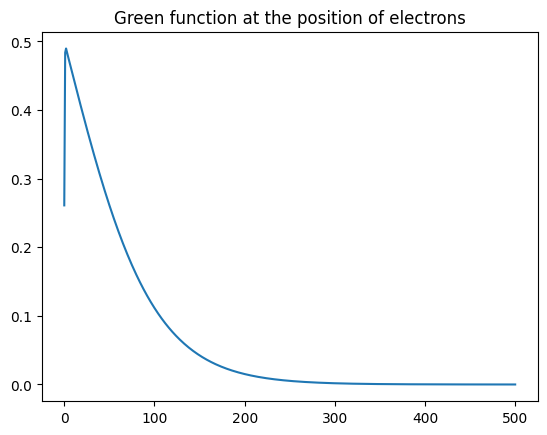

In [40]:
# # ------------ Load Green Function  ------------ #
G = np.load(GreenFuncName)

# here you can compare G with another Green function
plt.plot(G[position_of_electrons,0,:])
plt.title('Green function at the position of electrons')
plt.show()


In [41]:
dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))
dGzBOTTOM = np.zeros((N, N))

# # ----------- Green function difference along the charge pool ----------- #
for n in range(0, N):
    for i in range(0, N):
        dGr[n,i] = -4*np.pi*e*(G[position_of_electrons,i+1,n]-G[position_of_electrons,i,n])
    
# # ----------- Green function difference across the cell's top ----------- #
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz) #for testing
        

# # ----------- Green function difference across the cell's bottom ----------- #
        dGzBOTTOM[n,i] = -4 * np.pi * e * (G[1,i,n]-G[0,i,n])*(hr/hz)

## Choose the Voltage Sweep

### Here, we chose $V_{\mathrm{BC}} = 10\,\mathrm{V}$, $V_{\mathrm{BO}} = -32\,\mathrm{V}$, and swept $V_{\mathrm{BM}}$ from $-32\,\mathrm{V}$ to $10\,\mathrm{V}$.

Note that the naming convention for the voltages differs from that used in the plasmon paper, where $V_{\mathrm{BC}}$, $V_{\mathrm{BM}}$, and $V_{\mathrm{BO}}$ are used instead of $V_{\mathrm{ib}}$, $V_{\mathrm{mb}}$, and $V_{\mathrm{ob}}$.



In [42]:
Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Vit=0/300 #statvolt
Vmt=0/300 #statvolt
Vot=0/300 #statvolt

Vr=0/300 #statvolt

Vob =-32/300
Vib=10/300
# Vob = cp.arange(-96, -5.5, 0.5)/300
Vmb_start=-32
Vmb_stop=10
Vmb_step=0.2
Vmb = np.arange(Vmb_start, Vmb_stop, Vmb_step)/300
print(len(Vmb))
idx=np.abs(Vmb-6.8/300).argmin()
print(idx)
print(Vmb[idx]*300)


210
194
6.799999999999862


## Calculate the DC Potential Created by the Applied Electrode Voltages, $\tilde{\phi}$

*(If already calculated, skip this step and proceed to the loading section.)*


In [43]:
def phitilGen():


    phitilInitial = fitilSOLUT(R,H,N,M,Vib,Vmb[0],Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)
    phitilList = np.array(np.zeros((len(Vmb), np.shape(phitilInitial)[0], np.shape(phitilInitial)[1])))
  
    phitilList[0] = phitilInitial
    

    for i in range(1,len(Vmb)):
        print(len(Vmb) - i)
        print('Vmb ='+str(Vmb[i]*300))
        phitilList[i] = fitilSOLUT(R,H,N,M,Vib,Vmb[i],Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)

    return phitilList


phitilList = phitilGen()



0
2.2062511196435652e-06
7.317361424841184e-07
2.5714930675102554e-07
9.210530577119513e-08
3.3536152077573433e-08
1.238141671827675e-08
4.627144126190252e-09
1.7481742026204117e-09
6.67210828253495e-10
2.5713808166072383e-10
1.0004613110181637e-10
209
Vmb =-31.8
0
2.1973712954620472e-06
7.286743918324956e-07
2.5600044052664916e-07
9.166637485180651e-08
3.336517611501888e-08
1.2314352967890407e-08
4.6006326873127e-09
1.737576436899868e-09
6.629445464811923e-10
2.554094921669581e-10
208
Vmb =-31.6
0
2.188556761296978e-06
7.256150856005394e-07
2.548515742745172e-07
9.122744400874572e-08
3.319420012470875e-08
1.2247522912511855e-08
4.574121262312936e-09
1.7269786919960062e-09
6.586782508311018e-10
2.5368092348987403e-10
207
Vmb =-31.400000000000002
0
2.1797768214731894e-06
7.225726233531238e-07
2.5370270800850747e-07
9.078851309629599e-08
3.302322412745973e-08
1.2180692829377726e-08
4.54760978180202e-09
1.716380960969932e-09
6.544119413032234e-10
2.5195230624053266e-10
206
Vmb =-31.200000

2.812115212219579e-08
1.0256321514301447e-08
3.7859218399161065e-09
1.4125431380129783e-09
5.32255871321663e-10
2.0247717391619346e-10
177
Vmb =-25.400000000000027
0
1.9391548273933745e-06
6.343017654383831e-07
2.1984961318111118e-07
7.775001793081104e-08
2.795363310964527e-08
1.0190765245554623e-08
3.759881531117948e-09
1.402188122556769e-09
5.280976281274441e-10
2.007957827787621e-10
176
Vmb =-25.200000000000024
0
1.931754448417089e-06
6.3146909934364e-07
2.1875677361921086e-07
7.73213945925999e-08
2.7786114110972537e-08
1.0125209018441161e-08
3.733868984834299e-09
1.3918331279172413e-09
5.239508757415301e-10
1.9911439858022462e-10
175
Vmb =-25.000000000000025
0
1.9243767521506805e-06
6.286364332211414e-07
2.1766393407118834e-07
7.68927713168388e-08
2.7618595063727547e-08
1.0059652770511018e-08
3.7079960490959962e-09
1.3814781332777137e-09
5.198041511111917e-10
1.9743302132058105e-10
174
Vmb =-24.800000000000026
0
1.9169990558495775e-06
6.258037671055816e-07
2.165710945439825e-07
7.6

1.0861114820015505e-09
4.0140518686726523e-10
1.496502297082536e-10
145
Vmb =-19.000000000000046
0
1.7205067047026956e-06
5.461009740040379e-07
1.855656803703698e-07
6.436223554812104e-08
2.2879087686888955e-08
8.204018096813481e-09
2.940824285480037e-09
1.076101277530661e-09
3.973945478241703e-10
1.4803390457895915e-10
144
Vmb =-18.800000000000047
0
1.7143625236672178e-06
5.434454748605433e-07
1.8452102944210846e-07
6.395364119532454e-08
2.292459410149772e-08
8.231058879620834e-09
2.9156718810152693e-09
1.0660910730597717e-09
3.933862263716392e-10
1.4642864004654754e-10
143
Vmb =-18.600000000000048
0
1.708218342656026e-06
5.407899757448043e-07
1.8347637850690823e-07
6.354504682865025e-08
2.2970100529984272e-08
8.258099662428187e-09
2.8905194696116077e-09
1.0560808616499884e-09
3.8940475496906934e-10
1.4482337898358288e-10
142
Vmb =-18.40000000000005
0
1.7020741616205481e-06
5.381344765874319e-07
1.8243172759252468e-07
6.313645244809818e-08
2.3015606955001378e-08
8.285140441766092e-09


4.166460891574797e-10
1.4503655915154567e-10
113
Vmb =-12.600000000000069
0
1.5390750717041157e-06
4.642501309527758e-07
1.6092554310821738e-07
6.361414380678942e-08
2.433529325621131e-08
9.06932310848485e-09
3.3102202541546166e-09
1.1877417140093716e-09
4.2000277561404786e-10
1.4657325700384582e-10
112
Vmb =-12.400000000000068
0
1.5339407504269542e-06
4.618071331868867e-07
1.6098379198095647e-07
6.367691866154823e-08
2.438079967775897e-08
9.096363891292203e-09
3.3245715486129868e-09
1.1948440396813975e-09
4.2335944472338127e-10
1.4810995485614598e-10
111
Vmb =-12.20000000000007
0
1.5288064291532621e-06
4.593835444544059e-07
1.61042040857165e-07
6.373969350242925e-08
2.4426306116653862e-08
9.123404670630109e-09
3.3389228604185917e-09
1.2019463618839765e-09
4.267161277105025e-10
1.4964665617789308e-10
110
Vmb =-12.000000000000071
0
1.5236721078656923e-06
4.5696480147072727e-07
1.6110028973684298e-07
6.380246834677972e-08
2.4471812534732074e-08
9.150445453437461e-09
3.3532741652853026e-0

1.3875284047282221e-06
3.925153414918031e-07
1.627895070410723e-07
6.56229388676377e-08
2.5791498829003112e-08
9.934628123625666e-09
3.769461888458725e-09
1.4150160626558161e-09
5.27436479907939e-10
1.9576987947411695e-10
80
Vmb =-6.000000000000092
0
1.3831609664977096e-06
3.925356680950509e-07
1.628477559068725e-07
6.568571371892706e-08
2.583700525055077e-08
9.961668909902466e-09
3.783813203733777e-09
1.4221183848583951e-09
5.30798443393321e-10
1.9731335662576122e-10
79
Vmb =-5.800000000000093
0
1.3787935282602581e-06
3.9255599469482927e-07
1.6290600478481576e-07
6.574848857368587e-08
2.5882511675567876e-08
9.988709675362584e-09
3.798164501661594e-09
1.4292207070609741e-09
5.341603999398092e-10
1.9885725011103972e-10
78
Vmb =-5.600000000000094
0
1.374435278488767e-06
3.9257632129634235e-07
1.6296425364888123e-07
6.581126341109744e-08
2.5928018097115535e-08
1.0015750458169936e-08
3.812515803058858e-09
1.4363230327330001e-09
5.375223668946383e-10
2.0040114012687127e-10
77
Vmb =-5.400000

2.7247704401794914e-08
1.0800307911895679e-08
4.2295852029083925e-09
1.6430322657967622e-09
6.353107345757891e-10
2.452008353304169e-10
48
Vmb =0.3999999999998849
0
1.255182068581051e-06
3.931861192879582e-07
1.647117198449316e-07
6.769450879018368e-08
2.729321082681202e-08
1.0827393648327188e-08
4.2440105145480356e-09
1.650169764721987e-09
6.386872107577712e-10
2.4674816356817786e-10
47
Vmb =0.5999999999998806
0
1.2515275937471926e-06
3.9320644588600184e-07
1.6476996872460958e-07
6.775728363453415e-08
2.733871724835968e-08
1.0854479391697591e-08
4.258435829657126e-09
1.6573072740555528e-09
6.420636904092003e-10
2.4829549527538575e-10
46
Vmb =0.7999999999998836
0
1.2478731189029257e-06
3.9322677248924964e-07
1.6482821759734867e-07
6.782005847194572e-08
2.738422366643789e-08
1.0881663358580651e-08
4.272861148235663e-09
1.6644447799196715e-09
6.454401769995233e-10
2.498428304520406e-10
45
Vmb =0.9999999999998863
0
1.244218644058659e-06
3.9324709909249744e-07
1.6488646645967941e-07
6.7882

2.916207830772066e-10
1.1542530126140704e-10
18
Vmb =6.399999999999864
0
1.1512490433983336e-06
3.937959172813088e-07
1.664591860288389e-07
6.958091993899962e-08
2.866376418511618e-08
1.1642956418422834e-08
4.677110629347503e-09
1.8646442029313093e-09
7.400847781835473e-10
2.931681217233084e-10
1.1611801450928105e-10
17
Vmb =6.599999999999866
0
1.1480095568859594e-06
3.9381624388802605e-07
1.6651743490331272e-07
6.964411395846137e-08
2.8709539134919027e-08
1.167018298317557e-08
4.6915767694388766e-09
1.8717999650252892e-09
7.434655599491968e-10
2.9471544996106935e-10
1.1681072081826116e-10
16
Vmb =6.799999999999862
0
1.1447700703388908e-06
3.938365704808655e-07
1.66576114337888e-07
6.970730797445368e-08
2.8755314081252425e-08
1.1697409530581071e-08
4.706042906060803e-09
1.878955727119269e-09
7.468463417148463e-10
2.962627851377242e-10
1.1750344100502907e-10
15
Vmb =6.999999999999858
0
1.1415352425027392e-06
3.938568970841133e-07
1.666348401364176e-07
6.977050199391543e-08
2.88010890345

### Save PhiTilList

In [44]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '_Vmb_step='+ str(Vmb_step).replace('.','pt')+ '_Vmb_start=' +str(Vmb_start).replace('.','pt') +'_Vmb_stop='+ str(Vmb_stop).replace('.','pt') + '.npy'
fileName = "VmbSweep/Vib10V_Vobm32V/" + str(PhiTilName)

phitilNump = (phitilList)
np.save(fileName, phitilNump)
print(fileName)

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

VmbSweep/Vib10V_Vobm32V/Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0_Vmb_step=0pt2_Vmb_start=-32_Vmb_stop=10.npy


## Load PhiTilList if already calculated

In [45]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '_Vmb_step='+ str(Vmb_step).replace('.','pt')+ '_Vmb_start=' +str(Vmb_start).replace('.','pt') +'_Vmb_stop='+ str(Vmb_stop).replace('.','pt') + '.npy'
fileName = "VmbSweep/Vib10V_Vobm32V/" + str(PhiTilName)
print(fileName)
phitilNump=np.load(fileName)
print(np.shape(phitilNump))

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)


VmbSweep/Vib10V_Vobm32V/Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0_Vmb_step=0pt2_Vmb_start=-32_Vmb_stop=10.npy
(210, 201, 501)


## Calculate the DC Potential Created by the Applied DC Voltages, $\tilde{\phi}$

*(If already calculated, skip this step and proceed to the loading section.)*


In [46]:
#for each potential, calculates the density profile (depeding on the radus of the electron pool)
Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)
print(len(phitilNump))    

N_total_list = np.zeros(len(phitilNump))
N_per_ring_list = np.zeros((len(phitilNump), N+1))
denList = np.zeros((len(phitilNump), N+1))
density_max_list = np.zeros(len(phitilNump))
R_star_list = np.zeros(len(phitilNump))
Ertil_list=np.zeros((len(phitilNump), N))
Eztil_list = np.zeros((len(phitilNump), N+1))

for l in range(0, len(phitilNump)):


    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]

        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz


    radius_of_electron_pool = np.round(0.4/hr)
    
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])

    
    for k in range(0, len(radius_of_electron_pool_list)):

    

        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        

        # ------------- induced charge at the top inner electrode ------------------- #
        Ez = EztilTOP[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind=Qsum/e

        # ------------- induced charge at the bottom inner electrode ------------------- #
        Ez = EztilBOTTOM[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind = Qsum/e
        
        # ------------  potential at/below/above the electrons ------------ #


        copyAr2D(G_at_electrons, G[position_of_electrons].T)
        copyAr2D(G_below_electrons, G[position_of_electrons-1].T)
        copyAr2D(G_above_electrons, G[position_of_electrons+1].T)
        
        phi_at_electrons = phitil[position_of_electrons] - 4 * np.pi * e * hr * np.dot(density, G_at_electrons)
        phi_below_electrons = phitil[position_of_electrons-1] - 4 * np.pi * e * hr * np.dot(density, G_below_electrons)
        phi_above_electrons = phitil[position_of_electrons+1] - 4 * np.pi * e * hr * np.dot(density, G_above_electrons)

        # ---------- electric r-field across the liquid surface  ---------- #
        Er = np.zeros(N)

        Er[0:N] = (phi_at_electrons[0:N] - phi_at_electrons[1:N+1])/hr
        
        # ------------ electric field acting on electrons  ---------------- #
        Ezbelow[0:N+1] = (phi_below_electrons[0:N+1] - phi_at_electrons[0:N+1])/hz
        Ezabove[0:N+1] = (phi_at_electrons[0:N+1] - phi_above_electrons[0:N+1])/hz
        
        # adds the electric field acting on the electrons at the center to a list 
        Ezuplist[k] = Ezabove[0]
    
    
    minimum = np.amin(np.abs(Ezuplist))
    # chooses the index of the smallest absolute value of the electric field acting on the electrons at the center
    idx = np.argmin(np.abs(Ezuplist))

    # chooses the radius of the electron pool accordingly
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    #calculates the final density profile with the chosen radius of the electron pool
    # this is done for every potential in the Vob sweep
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
    
    # check eq 56 
    print(np.max(np.abs(np.dot(density[:int(radius_of_electron_pool)+1], dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]) -Ertil[:int(radius_of_electron_pool)+1])))
    
    N_total_list[l] = N_total
    print(N_total*1e-7)
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    N_per_ring_list[l] = N_per_ring
    Ertil_list[l]=Ertil
    Eztil_list[l] = Eztil

colors = plt.cm.jet(np.linspace(0,1,len(denList)))

print(N_total_list)




210
Iterations Left: 211
1.0408340855860843e-16
1.380040702201357
Iterations Left: 210
1.2836953722228372e-16
1.373958284685999
Iterations Left: 209
1.1102230246251565e-16
1.3678758620754952
Iterations Left: 208
1.0408340855860843e-16
1.3617934373647431
Iterations Left: 207
1.1102230246251565e-16
1.3557110074021756
Iterations Left: 206
1.0581813203458523e-16
1.3915788142347922
Iterations Left: 205
1.3704315460216776e-16
1.3853079851625465
Iterations Left: 204
9.194034422677078e-17
1.3790371537793251
Iterations Left: 203
9.71445146547012e-17
1.3727663200726612
Iterations Left: 202
1.0061396160665481e-16
1.4088271917739517
Iterations Left: 201
1.1796119636642288e-16
1.4023628233070822
Iterations Left: 200
1.1102230246251565e-16
1.3958984489017094
Iterations Left: 199
9.020562075079397e-17
1.3894340719423834
Iterations Left: 198
1.1449174941446927e-16
1.3829696888604799
Iterations Left: 197
1.214306433183765e-16
1.4190016234179172
Iterations Left: 196
9.71445146547012e-17
1.41233847386452

1.1102230246251565e-16
2.0609309442491033
Iterations Left: 78
2.0556473190325164e-16
2.0399905786793915
Iterations Left: 77
1.1796119636642288e-16
2.066351715263493
Iterations Left: 76
1.0408340855860843e-16
2.0923708274471697
Iterations Left: 75
1.1796119636642288e-16
2.0705277270487032
Iterations Left: 74
1.0408340855860843e-16
2.0957245338194936
Iterations Left: 73
1.0928757898653885e-16
2.120526733796148
Iterations Left: 72
1.1102230246251565e-16
2.1449103384045967
Iterations Left: 71
1.1102230246251565e-16
2.1217000537549824
Iterations Left: 70
1.6653345369377348e-16
2.145184603120619
Iterations Left: 69
9.71445146547012e-17
2.168205599051814
Iterations Left: 68
1.1709383462843448e-16
2.190742925438177
Iterations Left: 67
1.5265566588595902e-16
2.1661603272045205
Iterations Left: 66
1.249000902703301e-16
2.1877389656734825
Iterations Left: 65
1.0755285551056204e-16
2.2087995757788486
Iterations Left: 64
9.974659986866641e-17
2.2293273298237506
Iterations Left: 63
1.249000902703301

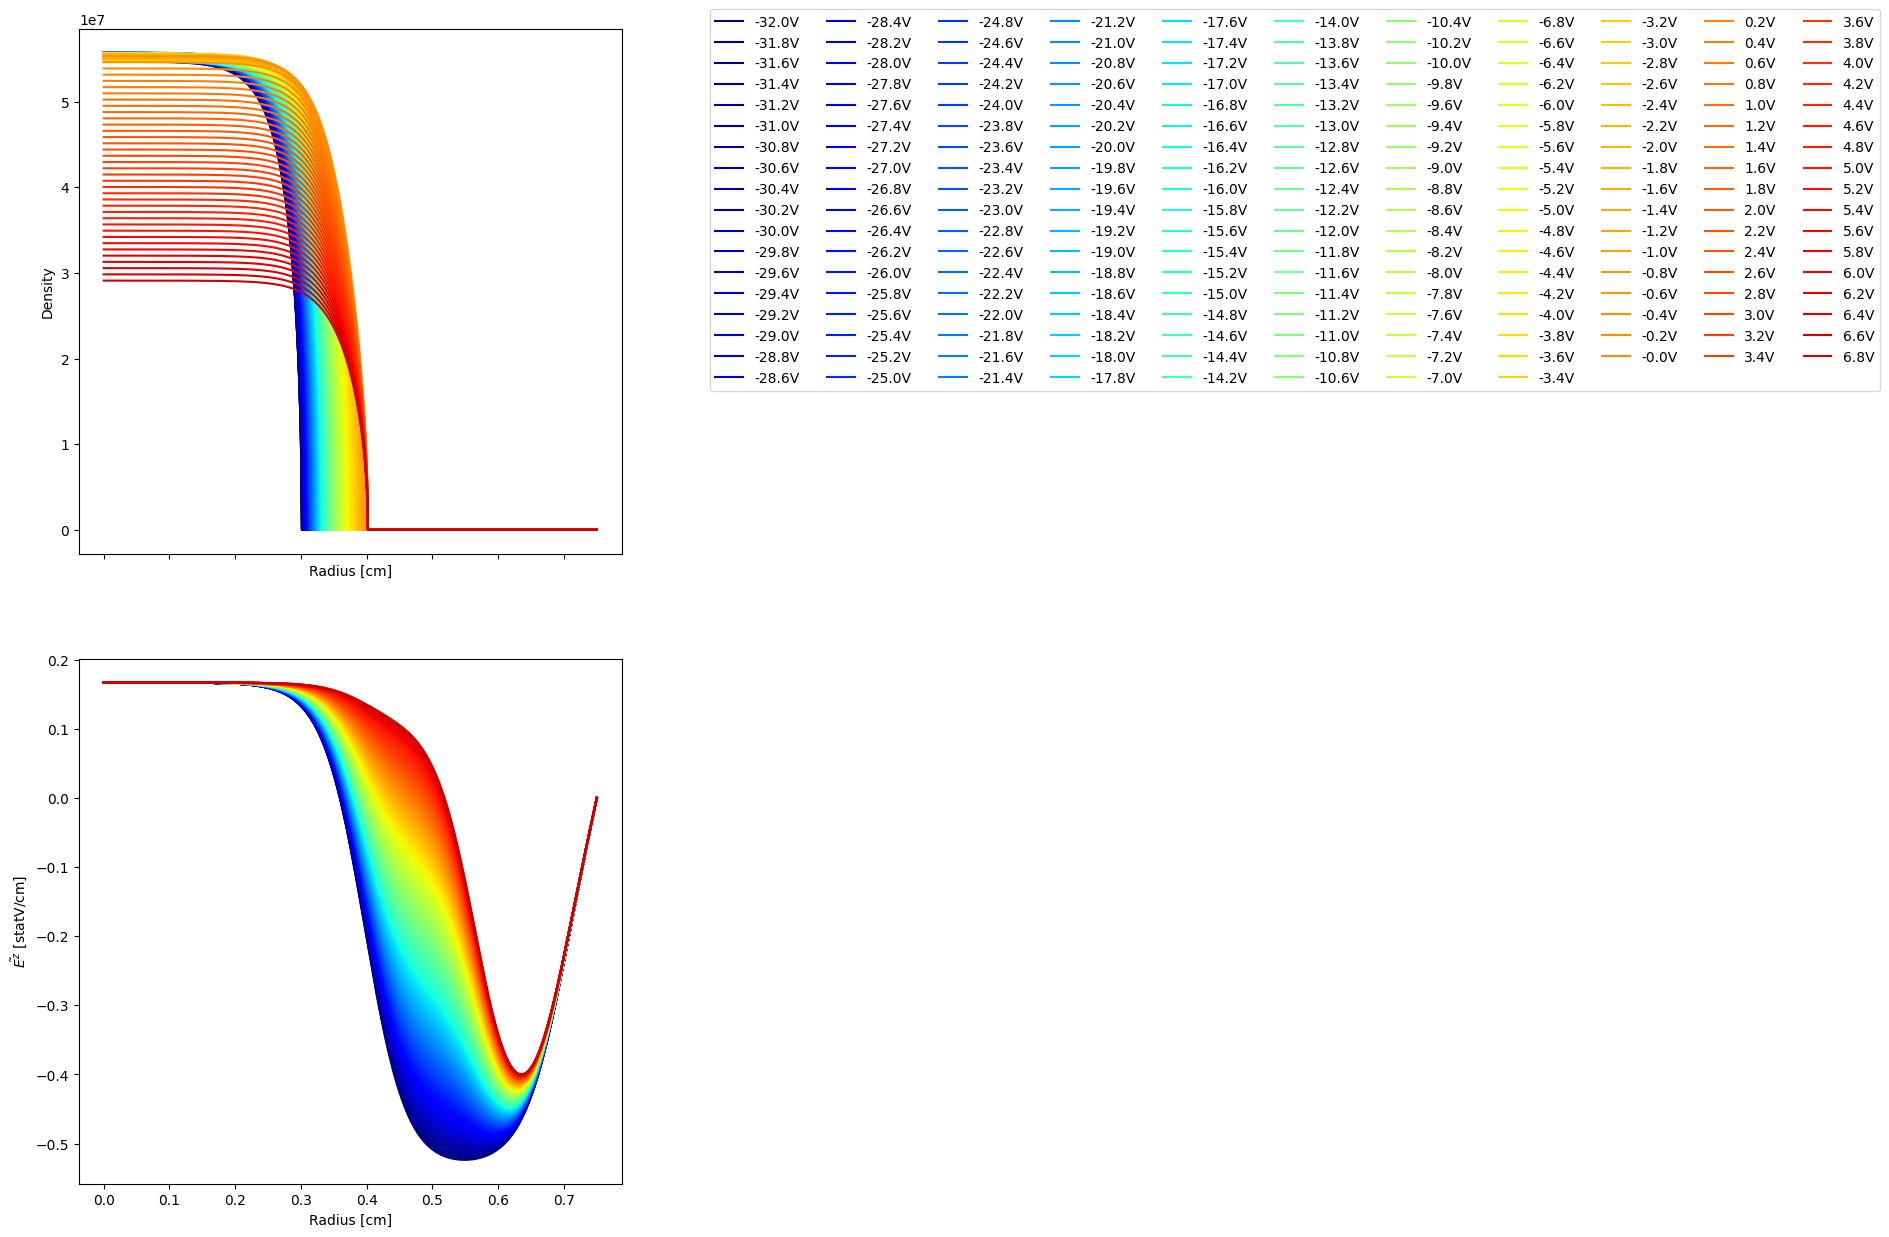

In [47]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7, 15), sharex=True)

for d in range(0, 195):
    ax1.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(np.round(Vmb[d] * 300,1))+'V')
    ax2.plot(np.arange(0, len(Eztil_list[d])) * hr, Eztil_list[d] , color = colors[d], label = str(np.round(Vmb[d] * 300,1))+'V')


ax1.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
ax1.set_ylabel("Density")
# ax2.set_ylabel(r"$\tilde{E^r}$ [statV/cm]")
ax2.set_ylabel(r"$\tilde{E^z}$ [statV/cm]")
ax1.set_xlabel("Radius [cm]")
ax2.set_xlabel("Radius [cm]")
plt.show()


### Run if you want to save the saturated densities

In [48]:
for idx in range(len(denList)):
    Vmb_str = f"{Vmb[idx] * 300:.1f}".replace(".", "p")
    # filename = f"DensityFiles/Saturated_density/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    filename = f"VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib{int(Vib*300)}_Vob{int(Vob*300)}_Vmb{Vmb_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-32p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-31p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-31p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-31p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-31p2_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-31p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-30p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-30p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb-30p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_den

VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb3p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb4p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb4p2_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb4p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb4p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb4p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb5p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb5p2_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_Vmb5p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/saturated_density/saturated_density_Vib10_Vob-32_

## Fixed N Density List

In [49]:
Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)

N_Fixed_list = np.copy(N_total_list)

# fix the number of electrons to be equal to the number of electrons at Vob=-96V 
# indeed the sweep of Vob is done from -96V to -5.5V, so the number of electrons at Vob=-96V is the one that is fixed



N_Fixed = N_total_list[0]

for l in range(0, len(phitilNump)):
    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]



        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    radius_of_electron_pool = np.round(0.4/hr)
    print(radius_of_electron_pool)
    
    #radius_of_electron_pool_list = np.arange(radius_of_electron_pool - 350,radius_of_electron_pool+1)
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])


    N_total_vect = np.zeros(len(radius_of_electron_pool_list))
    for k in range(0, len(radius_of_electron_pool_list)):
        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        N_total_vect[k] = N_total
    minimum = np.amin(np.abs(N_total_vect - N_Fixed))
    idx = np.argmin(np.abs(N_total_vect - N_Fixed))    

    
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)

    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    print((N_total-N_Fixed)/N_Fixed)
    


Iterations Left: 211
267.0
0.0
Iterations Left: 210
267.0
-0.0044074189302212895
Iterations Left: 209
267.0
-0.008814841552468224
Iterations Left: 208
267.0
-0.01322226569658917
Iterations Left: 207
267.0
0.012904643794928596
Iterations Left: 206
267.0
0.008360704155341396
Iterations Left: 205
267.0
0.0038167591381814497
Iterations Left: 204
267.0
-0.0007271875535490005
Iterations Left: 203
267.0
-0.005271135928883923
Iterations Left: 202
267.0
-0.00981508981682398
Iterations Left: 201
267.0
-0.014359044069557058
Iterations Left: 200
267.0
0.011490781884227846
Iterations Left: 199
267.0
0.0068065889115029475
Iterations Left: 198
267.0
0.0021223915022583577
Iterations Left: 197
267.0
-0.0025618118112046054
Iterations Left: 196
267.0
-0.007246014478396679
Iterations Left: 195
267.0
-0.011930221750060902
Iterations Left: 194
267.0
0.01374702019171515
Iterations Left: 193
267.0
0.008918780424532148
Iterations Left: 192
267.0
0.004090534386071065
Iterations Left: 191
267.0
-0.00073771384708

0.00896656046838233
Iterations Left: 40
267.0
-0.007521065039468226
Iterations Left: 39
267.0
-0.0007779206713018019
Iterations Left: 38
267.0
0.005631390164188581
Iterations Left: 37
267.0
-0.011518814235779473
Iterations Left: 36
267.0
-0.005779557308175776
Iterations Left: 35
267.0
-0.00038189536006107827
Iterations Left: 34
267.0
0.004672472196685523
Iterations Left: 33
267.0
0.009383263153370687
Iterations Left: 32
267.0
-0.00909020513580022
Iterations Left: 31
267.0
-0.005050094132430988
Iterations Left: 30
267.0
-0.001347800932683011
Iterations Left: 29
267.0
0.002021473294037552
Iterations Left: 28
267.0
0.005064235866852474
Iterations Left: 27
267.0
0.007788752273430851
Iterations Left: 26
267.0
0.010205094833291765
Iterations Left: 25
267.0
-0.010204344025099824
Iterations Left: 24
267.0
-0.008396266323350788
Iterations Left: 23
267.0
-0.006866554035317533
Iterations Left: 22
267.0
-0.005599103641267979
Iterations Left: 21
267.0
-0.004575887027857
Iterations Left: 20
267.0
-0

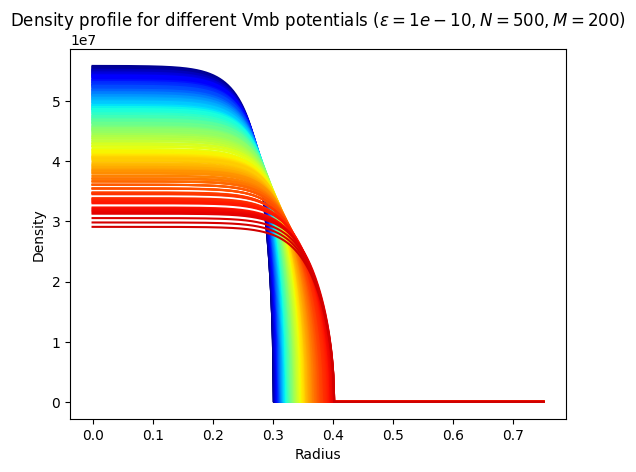

In [50]:
colors = plt.cm.jet(np.linspace(0,1,len(denList)))
for d in range(0, 195):
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(Vmb[d] * 300)+'V')

plt.ylabel("Density")
plt.xlabel("Radius")
# plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.title(f'Density profile for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.show()


plt.show()

In [51]:
#the file DensityFiles/EPS{int(np.log10(eps))} needs to be created before running the code
for idx in range(len(denList)):
    Vmb_str = f"{Vmb[idx] * 300:.1f}".replace(".", "p")
    filename = f"VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib{int(Vib*300)}_Vob{int(Vob*300)}_Vmb{Vmb_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    # filename = f"DensityFiles/EPS{int(np.log10(eps))}/FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-32p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-31p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-31p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-31p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-31p2_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-31p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-30p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-30p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-30p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_

VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-3p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-2p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-2p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-2p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-2p2_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-2p0_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-1p8_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-1p6_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/FixedN_Vib10_Vob-32_Vmb-1p4_N500_M200_posiE100.npy
VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/F